In [5]:
## check if notebook is running on Colab--if so, run appropriate installs and mount Google Drive
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab

if 'google.colab' in str(get_ipython()):
  # install RDKit and DeepChem
  !pip install rdkit-pypi --pre deepchem git+https://github.com/PatWalters/clusterama.git
  # mount Google Drive
  from google.colab import drive
  drive.mount('/content/drive')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import sys
import math

from time import time

from ipywidgets import interact

from matplotlib.gridspec import GridSpec

import useful_rdkit_utils as uru

from tqdm.auto import tqdm

from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, PandasTools, Descriptors, Draw, rdmolops, rdMolDescriptors, Lipinski, rdFMCS, MACCSkeys

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE

from IPython.core.display import HTML

import mols2grid

from minisom import MiniSom


## FUNCTIONS

In [7]:
tqdm.pandas()

In [8]:
# function for plotting distibutions as a histogram

def distribution(column, zoom_in='no'):
    plt.figure(figsize=(12, 8))
    sns.histplot(herg_df, x=column, hue='herg_inhibitor')
    if zoom_in == 'zoom':
        plt.xlim(herg_df.logP.quantile(0.001), herg_df.logP.quantile(0.999));

In [9]:
# function for plotting boxplots grouped by herg_inhibitor

def outliers(df, column):
    plt.figure(figsize=(8, 10))
    sns.boxplot(data=df, x='herg_inhibitor', y=column, hue='herg_inhibitor', )

In [10]:
# workaround for bug where molecular structure does not print with dataframe
# https://github.com/rdkit/rdkit/issues/2673
def show(df):
    return HTML(df.to_html(notebook=True))


In [12]:
# check if notebook is running on Colab and set path for data file 

def get_home_path():
  if 'google.colab' in str(get_ipython()):
    path = '/content/drive/MyDrive/GA/Capstone/ka_capstone'
  else:
    path = '..'
  
  return path


In [13]:
# view all columns in dataframe
pd.set_option('display.max.columns', None)

## Read data

In [14]:
    
# read hERG data into dataframe 
herg_df = pd.read_csv(f'{get_home_path()}/data/interim/herg_data.csv')


In [15]:
herg_df['mol'] = herg_df.SMILES.progress_apply(Chem.MolFromSmiles)
herg_df['fp'] = herg_df.mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/306865 [00:00<?, ?it/s]

  0%|          | 0/306865 [00:00<?, ?it/s]

In [16]:
show(herg_df.head(5))

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix,label,mol,fp
0,22416348,Cc1occc1C(=O)NCc1ccco1,20.17528,30.99165,0,205.213,2.11102,55.38,1,3,4,2,2,3,0,0,22,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 0 1 0 0 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,10.22630,13.05888,0,366.464,2.15220,51.24,0,7,8,3,1,4,0,0,43,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,862531,C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O,2.04420,0.06288,0,276.214,2.30000,78.43,3,2,8,1,1,3,1,0,39,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,21.80250,17.87858,0,466.534,3.25700,81.45,0,7,8,4,3,7,1,0,56,0,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,8.33980,19.03128,0,550.700,3.10920,100.21,2,6,9,6,1,9,5,0,68,1,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
X = np.stack(herg_df.fp)

In [24]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(X)
cluster_list = km.predict(X)

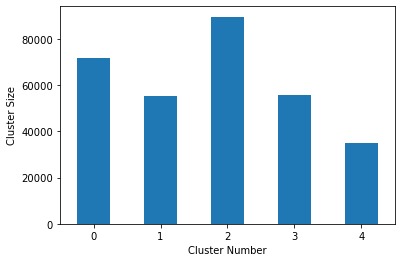

In [25]:
ax = pd.Series(cluster_list).value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Cluster Size")
ax.tick_params(axis='x', rotation=0)

In [26]:
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[]) 
    ax.yaxis.grid(False) 

In [27]:
tsne = TSNE(n_components=2, init='pca',learning_rate='auto')
crds = tsne.fit_transform(X,cluster_list)

/home/kajayi/miniconda3/envs/capstone_cf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


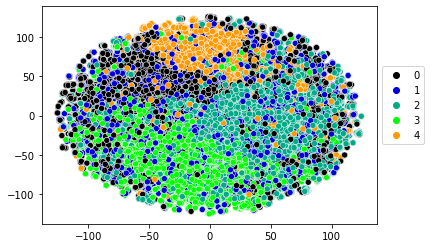

In [28]:
# 5
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=cluster_list,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

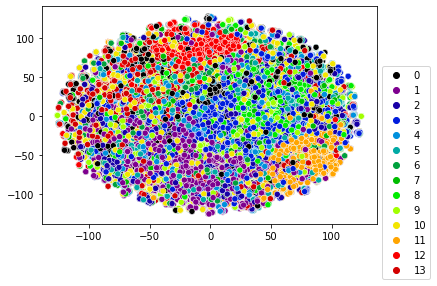

In [22]:
# 14
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=cluster_list,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

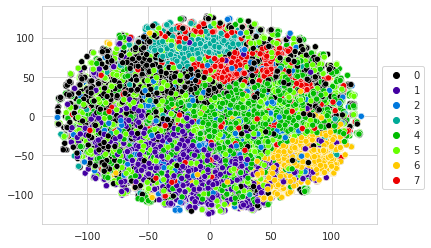

In [62]:
# 8
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=cluster_list,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

In [29]:
# cluster_range = [5,8,14]
# score_list = []
# for k in tqdm(cluster_range):
#     km = KMeans(n_clusters=k,random_state=42)
#     cluster_labels = km.fit_predict(X)
#     score = silhouette_score(X,cluster_labels)
#     score_list.append([k,score])

  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
score_df.head()

,K,Silhouette Score
0,5,0.016103
1,8,0.018764
2,14,0.018610


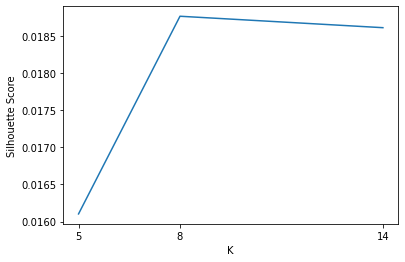

In [32]:
ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)
ax.set_xticks(cluster_range);

In [1]:
herg_df.mol[103883]

NameError: name 'herg_df' is not defined

In [49]:
len(herg_df.fp[103883].ToList())

2048

In [46]:
dir(herg_df.fp[103883])

['FromBase64',
 'GetBit',
 'GetNumBits',
 'GetNumOffBits',
 'GetNumOnBits',
 'GetOnBits',
 'SetBit',
 'SetBitsFromList',
 'ToBase64',
 'ToBinary',
 'ToBitString',
 'ToList',
 'UnSetBit',
 'UnSetBitsFromList',
 '__add__',
 '__and__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getinitargs__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__instance_size__',
 '__invert__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__safe_for_unpickling__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '__xor__']

In [39]:
show(herg_df.loc[(herg_df.mw<80) & (herg_df.SMILES_length<8), ['fp']])

,fp
96750,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
103883,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
176962,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [30]:
show(herg_df.loc[herg_df.SMILES_length < 8, :])

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix,label,mol,fp
5620,49679190,OCCNCCO,3.9569,-2.71462,0,105.137,-1.4394,52.49,3,3,3,0,0,4,0,0,7,0,[[0 1 0 0 0 0 0]\n [1 0 1 0 0 0 0]\n [0 1 0 1 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36993,85148636,CCCCCO,12.6115,16.67788,0,88.150,1.1689,20.23,1,1,1,0,0,3,0,0,6,0,[[0 1 0 0 0 0]\n [1 0 1 0 0 0]\n [0 1 0 1 0 0]...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
96750,49640652,NC(N)=O,14.9295,15.95348,0,60.056,-0.9762,69.11,2,1,3,0,0,0,0,0,7,0,[[0 1 0 0]\n [1 0 1 1]\n [0 1 0 0]\n [0 1 0 0]],inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
103883,49816670,CC(O)CO,15.7274,17.73608,0,76.095,-0.6405,40.46,2,2,2,0,0,1,1,0,7,0,[[0 1 0 0 0]\n [1 0 1 1 0]\n [0 1 0 0 0]\n [0 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
137685,49816810,CCCCCCO,21.8775,26.41568,0,102.177,1.5590,20.23,1,1,1,0,0,4,0,0,7,0,[[0 1 0 0 0 0 0]\n [1 0 1 0 0 0 0]\n [0 1 0 1 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
176962,56462809,OCC1CO1,12.7153,15.84548,0,74.079,-0.6225,32.76,1,2,2,1,0,1,1,0,7,0,[[0 1 0 0 0]\n [1 0 1 0 0]\n [0 1 0 1 1]\n [0 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
202531,49734164,OCCOCCO,13.7132,4.84908,0,106.121,-1.0124,49.69,2,3,3,0,0,4,0,0,7,0,[[0 1 0 0 0 0 0]\n [1 0 1 0 0 0 0]\n [0 1 0 1 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
248357,11533072,Cl.NCCS,8.3654,14.91388,0,113.613,0.2967,26.02,2,2,3,0,0,1,0,0,7,0,[[0 0 0 0 0]\n [0 0 1 0 0]\n [0 1 0 1 0]\n [0 ...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
274897,49816801,OCCCCO,9.6225,13.67348,0,90.122,-0.2488,40.46,2,2,2,0,0,3,0,0,6,0,[[0 1 0 0 0 0]\n [1 0 1 0 0 0]\n [0 1 0 1 0 0]...,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
herg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306865 entries, 0 to 306864
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Pubchem_SID          306865 non-null  int64  
 1   SMILES               306865 non-null  object 
 2   hERG_at_1uM          306865 non-null  float64
 3   hERG_at_10uM         306865 non-null  float64
 4   herg_inhibitor       306865 non-null  int64  
 5   mw                   306865 non-null  float64
 6   logP                 306865 non-null  float64
 7   PSA                  306865 non-null  float64
 8   H_bond_donors        306865 non-null  int64  
 9   H_bond_acceptors     306865 non-null  int64  
 10  num_heteroatoms      306865 non-null  int64  
 11  total_num_rings      306865 non-null  int64  
 12  aromatic_rings       306865 non-null  int64  
 13  num_rotatable_bonds  306865 non-null  int64  
 14  num_stereocenters    306865 non-null  int64  
 15  formal_charge    

In [11]:
# get distribution of active and inactive compounds
herg_df['label'].value_counts(normalize=True).round(3)*100


inactive    95.5
active       4.5
Name: label, dtype: float64

In [14]:
herg_df.describe()

,Pubchem_SID,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations
count,3.068650e+05,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000,306865.00000,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000,306865.000000
mean,2.810340e+07,6.246021,-2.777348,0.044788,360.740823,2.938132,74.905614,1.171463,4.889479,6.94962,3.004445,2.264918,4.975784,0.395842,0.000257,43.339016,0.078435
std,1.809249e+07,11.196587,20.572885,0.206839,78.630572,1.248801,28.200163,0.891638,1.835904,2.22014,0.984356,0.914907,2.344302,0.874818,0.030367,11.073268,0.304246
min,8.421210e+05,-299.017000,-284.172920,0.000000,60.056000,-13.054800,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-3.000000,6.000000,0.000000
25%,1.474224e+07,2.781400,-10.247820,0.000000,306.409000,2.178220,55.400000,1.000000,4.000000,5.00000,2.000000,2.000000,3.000000,0.000000,0.000000,36.000000,0.000000
50%,2.480566e+07,8.253800,1.635380,0.000000,358.419000,2.982200,72.950000,1.000000,5.000000,7.00000,3.000000,2.000000,5.000000,0.000000,0.000000,43.000000,0.000000
75%,4.966690e+07,12.443000,10.515580,0.000000,412.352000,3.749100,91.980000,2.000000,6.000000,8.00000,4.000000,3.000000,6.000000,1.000000,0.000000,50.000000,0.000000
max,8.514922e+07,126.489200,213.104180,1.000000,1701.206000,12.605800,777.980000,25.000000,46.000000,46.00000,22.000000,10.000000,55.000000,30.000000,2.000000,263.000000,4.000000


In [16]:
# columns to exclude from EDA
no_eda_columns = ['Pubchem_SID', 'SMILES', 'adjacency_matrix', 'label']
target_columns = ['herg_inhibitor', 'hERG_at_1uM',	'hERG_at_10uM']

In [13]:
# separate variables into continuous and discrete
eda_columns_dis = [i for i in herg_df.columns.symmetric_difference(no_eda_columns).symmetric_difference(target_columns) if herg_df[i].nunique() / herg_df.shape[0] < 0.05]
eda_columns_con = [i for i in herg_df.columns.symmetric_difference(no_eda_columns).symmetric_difference(target_columns) if herg_df[i].nunique() / herg_df.shape[0] > 0.05]

In [ ]:
herg_df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)
herg_df['fp'] = df.mol.progress_apply(uru.mol2morgan_fp)

## Cluster and view

In [12]:

butina_cluster = ButinaCluster("rdkit")

In [13]:
herg_df['Cluster'] = butina_cluster.cluster_smiles(herg_df.SMILES, sim_cutoff=0.7)


Calculating Fingerprints:   0%|          | 0/306865 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
cluster_rows = [[v.SMILES.values[0],k,len(v)] for k,v in herg_df.groupby("Cluster")]
cluster_df = pd.DataFrame(cluster_rows,columns=["SMILES","Cluster","Num"])

In [11]:
herg_df.head()

,Pubchem_SID,SMILES,hERG_at_1uM,hERG_at_10uM,herg_inhibitor,mw,logP,PSA,H_bond_donors,H_bond_acceptors,num_heteroatoms,total_num_rings,aromatic_rings,num_rotatable_bonds,num_stereocenters,formal_charge,SMILES_length,ro5_violations,adjacency_matrix
0,22416348,Cc1occc1C(=O)NCc1ccco1,20.17528,30.99165,0,205.213,2.11102,55.38,1,3,4,2,2,3,0,0,22,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 0 1 0 0 ...
1,26665387,COc1ccc(/C=C2\SC(=S)N(N3CCOCC3)C2=O)c(OC)c1,10.22630,13.05888,0,366.464,2.15220,51.24,0,7,8,3,1,4,0,0,43,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,862531,C[C@H](NC(=O)Nc1cccc(C(F)(F)F)c1)C(=O)O,2.04420,0.06288,0,276.214,2.30000,78.43,3,2,8,1,1,3,1,0,39,0,[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]\n [1 ...
3,26732361,COc1cc(OC)c2ccc(=O)oc2c1C(CC(=O)N1CCOCC1)c1ccc...,21.80250,17.87858,0,466.534,3.25700,81.45,0,7,8,4,3,7,1,0,56,0,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...
4,49735227,COc1cccc(NC(=O)C2C3C=CC4(O3)C2C(=O)N(CCCN2CCCC...,8.33980,19.03128,0,550.700,3.10920,100.21,2,6,9,6,1,9,5,0,68,1,[[0 1 0 ... 0 0 0]\n [1 0 1 ... 0 0 0]\n [0 1 ...


In [ ]:
# pca = PCA(n_components=2)
# crds = pca.fit_transform(fp_list)

In [ ]:
def conv_net():
  K.clear_session()
  weights = 'imagenet'
  inputs = Input(shape=(128, 128, 3))

  base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

  for layer in base_model.layers:
    layer.trainable = False

  x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

  x = Flatten()(x)

  base_resnet = base_model(inputs)
  base_resnet = Flatten()(base_resnet)

  concated_layers = Concatenate()([x, base_resnet])

  concated_layers = Dense(2024, activation='relu')(concated_layers)
  concated_layers = Dense(524, activation='relu')(concated_layers)
  concated_layers = Dense(124, activation='relu')(concated_layers)
  output = Dense(4, activation='relu')(concated_layers)

  model = Model(inputs=inputs, outputs=output)
  return model